In [28]:
!pip install -q datasets transformers
import os

In [29]:
from huggingface_hub import notebook_login

notebook_login()

In [30]:
%%capture
!sudo apt -qq install git-lfs
!git config --global credential.helper store

In [31]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [32]:
!ls -al "/content/drive/MyDrive/Data2/"

total 1551372
-rw------- 1 root root 1588604321 Mar 14 09:27 FoodClassification.zip


In [33]:
!unzip "/content/drive/MyDrive/Data2/FoodClassification.zip" -d /tmp/foodimg

Archive:  /content/drive/MyDrive/Data2/FoodClassification.zip
replace /tmp/foodimg/Food Classification/burger/001.jpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [34]:
from datasets import load_dataset
ds = load_dataset("imagefolder", data_dir="/tmp/foodimg")
ds = ds['train']

Resolving data files:   0%|          | 0/6271 [00:00<?, ?it/s]

In [35]:
data = ds.train_test_split(test_size=0.15)

In [36]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5328
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
})

In [37]:
data.push_to_hub("himanshusoni/indian_food_images")

Uploading the dataset shards:   0%|          | 0/3 [00:00<?, ?it/s]

Map:   0%|          | 0/1776 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

Map:   0%|          | 0/1776 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

Map:   0%|          | 0/1776 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/18 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/941 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/10 [00:00<?, ?ba/s]

README.md:   0%|          | 0.00/943 [00:00<?, ?B/s]

CommitInfo(commit_url='https://huggingface.co/datasets/abhi5403/indian_food_images/commit/83f3a5d1e8be96da8b42edb6c91951d7321e278d', commit_message='Upload dataset', commit_description='', oid='83f3a5d1e8be96da8b42edb6c91951d7321e278d', pr_url=None, pr_revision=None, pr_num=None)

In [38]:
data = load_dataset("himanshusoni/indian_food_images")

Generating train split:   0%|          | 0/5328 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/941 [00:00<?, ? examples/s]

In [39]:
ex = data['train'][400]
ex

{'image': <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=1024x683>,
 'label': 17}

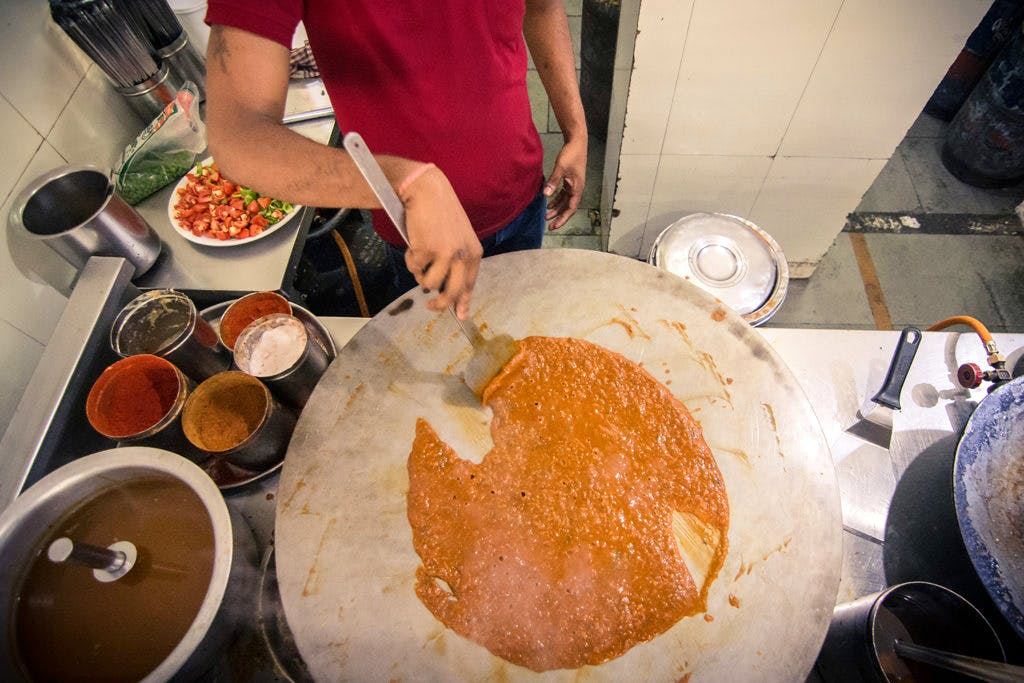

In [40]:
image = ex['image']
image


In [41]:
labels = data['train'].features['label']
labels

ClassLabel(names=['burger', 'butter_naan', 'chai', 'chapati', 'chole_bhature', 'dal_makhani', 'dhokla', 'fried_rice', 'idli', 'jalebi', 'kaathi_rolls', 'kadai_paneer', 'kulfi', 'masala_dosa', 'momos', 'paani_puri', 'pakode', 'pav_bhaji', 'pizza', 'samosa'], id=None)

In [42]:
labels.int2str(ex['label'])

'pav_bhaji'

In [43]:
from datasets import load_metric

metric = load_metric("accuracy")

<ipython-input-43-350fcae91df9>:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  metric = load_metric("accuracy")
/usr/local/lib/python3.10/dist-packages/datasets/load.py:756: FutureWarning: The repository for accuracy contains custom code which must be executed to correctly load the metric. You can inspect the repository content at https://raw.githubusercontent.com/huggingface/datasets/2.18.0/metrics/accuracy/accuracy.py
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this metric from the next major release of `datasets`.
  warnings.warn(


In [44]:
data

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 5328
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 941
    })
})

In [45]:
labels = data["train"].features["label"].names
label2id, id2label = dict(), dict()
for i, label in enumerate(labels):
    label2id[label] = i
    id2label[i] = label

In [46]:
from transformers import ViTFeatureExtractor

model_name_or_path = 'google/vit-base-patch16-224-in21k'
feature_extractor = ViTFeatureExtractor.from_pretrained(model_name_or_path)

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [47]:
from torchvision.transforms import (
    CenterCrop,
    Compose,
    Normalize,
    RandomHorizontalFlip,
    RandomResizedCrop,
    Resize,
    ToTensor,
)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
train_transforms = Compose(
        [
            RandomResizedCrop(feature_extractor.size),
            RandomHorizontalFlip(),
            ToTensor(),
            normalize,
        ]
    )

val_transforms = Compose(
        [
            Resize(feature_extractor.size['height']),
            CenterCrop(feature_extractor.size['width']),
            ToTensor(),
            normalize,
        ]
    )

def preprocess_train(example_batch):
    """Apply train_transforms across a batch."""
    example_batch["pixel_values"] = [
        train_transforms(image.convert("RGB")) for image in example_batch["image"]
    ]
    return example_batch

def preprocess_val(example_batch):
    """Apply val_transforms across a batch."""
    example_batch["pixel_values"] = [val_transforms(image.convert("RGB")) for image in example_batch["image"]]
    return example_batch

In [48]:
train_ds = data['train']
val_ds = data['test']

In [51]:
train_ds.set_transform(preprocess_train)
val_ds.set_transform(preprocess_val)

In [52]:
train_ds

Dataset({
    features: ['image', 'label'],
    num_rows: 5328
})

In [53]:
from transformers import ViTForImageClassification
model_name_or_path = 'google/vit-base-patch16-224-in21k'
model = ViTForImageClassification.from_pretrained(
    model_name_or_path,
    num_labels=len(labels),
    id2label={str(i): c for i, c in enumerate(labels)},
    label2id={c: str(i) for i, c in enumerate(labels)}
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [54]:
from transformers import TrainingArguments

training_args = TrainingArguments(
    'finetuned-indian-food',
  per_device_train_batch_size=16,
  evaluation_strategy="steps",
  num_train_epochs=4,
  fp16=False,
  save_steps=100,
  eval_steps=100,
  logging_steps=10,
  learning_rate=2e-4,
  save_total_limit=2,
  remove_unused_columns=False,
  push_to_hub=True,
  report_to='tensorboard',
  load_best_model_at_end=True,
  hub_strategy="end"
)#

In [60]:
import numpy as np
def compute_metrics(eval_pred):
    """Computes accuracy on a batch of predictions"""
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return metric.compute(predictions=predictions, references=eval_pred.label_ids)

In [61]:
import torch

def collate_fn(batch):
    return {
        'pixel_values': torch.stack([x['pixel_values'] for x in batch]),
        'labels': torch.tensor([x['label'] for x in batch])
    }

In [62]:
from transformers import Trainer
trainer = Trainer(
    model,
    training_args,
    train_dataset=train_ds,
    eval_dataset=val_ds,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
    data_collator=collate_fn,
)

In [63]:
metrics = trainer.evaluate()
trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

***** eval metrics *****
  eval_accuracy           =     0.0553
  eval_loss               =     2.9984
  eval_runtime            = 0:11:02.77
  eval_samples_per_second =       1.42
  eval_steps_per_second   =      0.178


In [64]:
kwargs = {
    "finetuned_from": model.config._name_or_path,
    "tasks": "image-classification",
    "dataset": 'indian_food_images',
    "tags": ['image-classification'],
}

if training_args.push_to_hub:
    trainer.push_to_hub('🍻 cheers', **kwargs)
else:
    trainer.create_model_card(**kwargs)

model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

Upload 4 LFS files:   0%|          | 0/4 [00:00<?, ?it/s]

events.out.tfevents.1710419056.e176ef3bbaa9.42432.0:   0%|          | 0.00/5.34k [00:00<?, ?B/s]

events.out.tfevents.1710420374.e176ef3bbaa9.42432.1:   0%|          | 0.00/346 [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/4.86k [00:00<?, ?B/s]

In [65]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("himanshusoni/finetuned-indian-food")
model = AutoModelForImageClassification.from_pretrained("himanshusoni/finetuned-indian-food")

preprocessor_config.json:   0%|          | 0.00/327 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.51k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


model.safetensors:   0%|          | 0.00/343M [00:00<?, ?B/s]

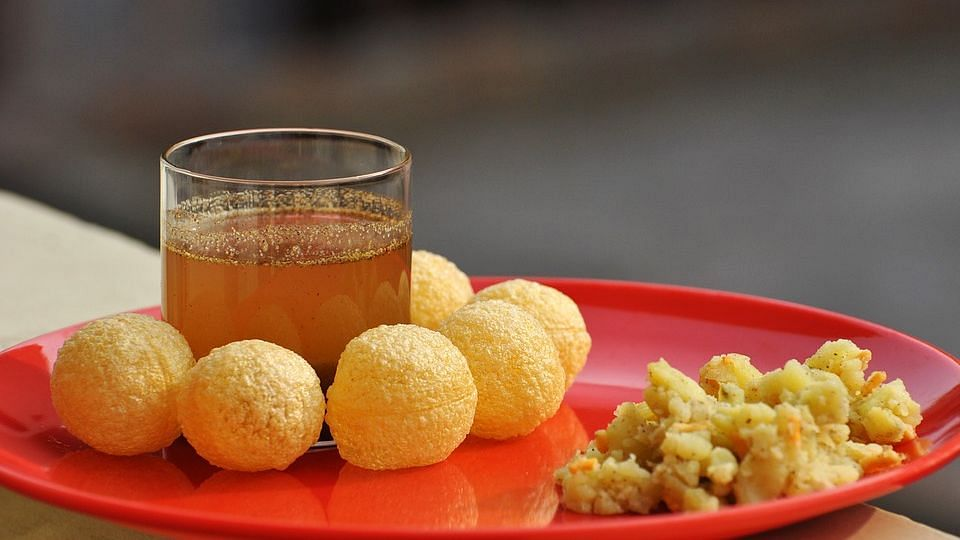

In [67]:
from PIL import Image
import requests

url = 'https://huggingface.co/rajistics/finetuned-indian-food/resolve/main/126.jpg'
image = Image.open(requests.get(url, stream=True).raw)
image

In [69]:
from transformers import AutoModelForImageClassification, AutoFeatureExtractor

repo_name = "himanshusoni/finetuned-indian-food"

feature_extractor = AutoFeatureExtractor.from_pretrained(repo_name)
model = AutoModelForImageClassification.from_pretrained(repo_name)

In [70]:
encoding = feature_extractor(image.convert("RGB"), return_tensors="pt")
print(encoding.pixel_values.shape)

torch.Size([1, 3, 224, 224])


In [71]:
import torch

# forward pass
with torch.no_grad():
  outputs = model(**encoding)
  logits = outputs.logits

In [72]:
predicted_class_idx = logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

Predicted class: kulfi


In [73]:
from transformers import pipeline
pipe = pipeline("image-classification", "himanshusoni/finetuned-indian-food")

In [76]:
url = 'https://huggingface.co/rajistics/finetuned-indian-food/resolve/main/126.jpg'
image = Image.open(requests.get(url, stream=True).raw)

pipe(image)

[{'label': 'kulfi', 'score': 0.06029164418578148},
 {'label': 'pav_bhaji', 'score': 0.060065608471632004},
 {'label': 'samosa', 'score': 0.05681893974542618},
 {'label': 'butter_naan', 'score': 0.05397436395287514},
 {'label': 'burger', 'score': 0.05305628478527069}]

In [77]:
pipe = pipeline("image-classification",
                model=model,
                feature_extractor=feature_extractor)

In [78]:
pipe(image)

[{'label': 'kulfi', 'score': 0.06029164418578148},
 {'label': 'pav_bhaji', 'score': 0.060065608471632004},
 {'label': 'samosa', 'score': 0.05681893974542618},
 {'label': 'butter_naan', 'score': 0.05397436395287514},
 {'label': 'burger', 'score': 0.05305628478527069}]